In [21]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import lightgbm          as lgb


from sklearn                 import linear_model, model_selection, preprocessing
from sklearn.metrics         import mean_squared_error, r2_score, roc_curve, auc
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [466]:
def read_data(file):
    df = pd.read_csv(file)
    return df

def set_data_types(df):
    int_columns = ['Store_ID','Fiscal_Qtr','Fiscal_dayofWk','Hour']
    num_columns = ['AvgHourlyTemp','SalesRevenue']
    
    for col in int_columns:
        df[col] = df[col].astype(int)
    
    for col in num_columns:
        df[col] = df[col].astype(float)

    df['date'] = pd.to_datetime(df['DateStringYYYYMMDD'], format='%Y%m%d')
    df.drop('DateStringYYYYMMDD', axis=1, inplace=True)
        
    return df

def preprocess_data(df, trim_hours=False, clip_outliers=False):
    temp = pd.get_dummies(df, dummy_na=False)
    rows_before = temp.shape[0]
    temp = temp[temp['SalesRevenue'] >= 0]
    
    if trim_hours == True:
        temp = temp[temp['Hour'] >= 7]
        temp = temp[temp['Hour'] <= 20]
    
    if clip_outliers == True:
        temp = temp.apply(lambda col: col.clip(*col.quantile([0.05,0.95]).values))
        
    rows_after = temp.shape[0]
    print("Rows before:{0} after:{1}".format(rows_before, rows_after))
    return temp


    
    
df_raw          = read_data('data/SalesByHour.csv')
df_typed        = set_data_types(df_raw)
df_basic = preprocess_data(df_typed)
df_neat  = preprocess_data(df_typed, trim_hours=True, clip_outliers=False)
df = df_basic.copy()

Rows before:125792 after:125328
Rows before:125792 after:120955


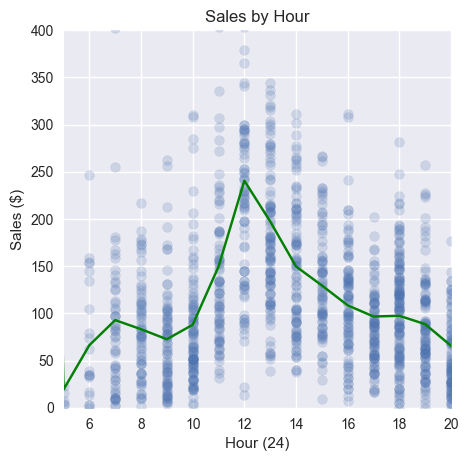

In [443]:
salesByHour = df.groupby('Hour')['SalesRevenue'].mean()
temp = df.sample(frac=.01)

plt.figure(figsize=(5,5),dpi=100)
plt.title("Sales by Hour")
plt.xlabel('Hour (24)')
plt.ylabel('Sales ($)')
plt.scatter(x=temp['Hour'], y=temp['SalesRevenue'], alpha=.2)
plt.plot(salesByHour.index.values, salesByHour.values, color='g')
plt.ylim(0,400)
plt.xlim(5,20)
plt.show()


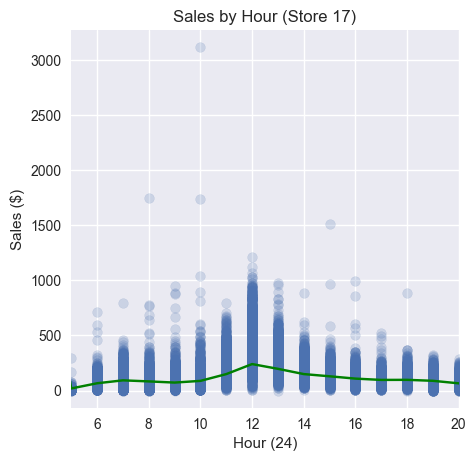

In [482]:
store = 17

salesByHour = df.groupby('Hour')['SalesRevenue'].mean()
temp = df[df['Store_ID'] == store]

plt.figure(figsize=(5,5),dpi=100)
plt.title("Sales by Hour (Store {0})".format(store))
plt.xlabel('Hour (24)')
plt.ylabel('Sales ($)')
plt.scatter(x=temp['Hour'], y=temp['SalesRevenue'], alpha=.2)
plt.plot(salesByHour.index.values, salesByHour.values, color='g')
#plt.ylim(0,400)
plt.xlim(5,20)
plt.show()


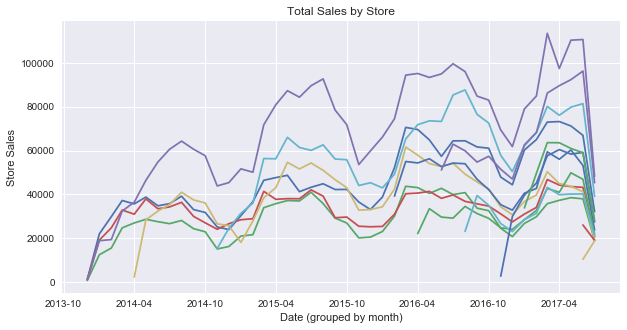

In [444]:
storeIDs = np.unique(df_preprocessed['Store_ID'])
df['year_month'] = df['date'].dt.to_period(freq='M').dt.to_timestamp()

plt.figure(figsize=(10,5))
plt.title("Total Sales by Store")
plt.xlabel("Date (grouped by month)")
plt.ylabel("Store Sales")
for storeID in storeIDs:
    plt.plot(df[df['Store_ID'] == storeID].groupby('year_month')['SalesRevenue'].sum())
plt.show()

In [483]:
df.columns

Index(['Store_ID', 'Fiscal_Qtr', 'Fiscal_dayofWk', 'Hour', 'AvgHourlyTemp',
       'SalesRevenue', 'date', 'Daypart_Afternoon', 'Daypart_Breakfast',
       'Daypart_Dinner', 'Daypart_Late Night', 'Daypart_Lunch',
       'HourlyWeather_clear-day', 'HourlyWeather_clear-night',
       'HourlyWeather_cloudy', 'HourlyWeather_fog',
       'HourlyWeather_partly-cloudy-day', 'HourlyWeather_partly-cloudy-night',
       'HourlyWeather_rain', 'HourlyWeather_snow', 'HourlyWeather_wind'],
      dtype='object')

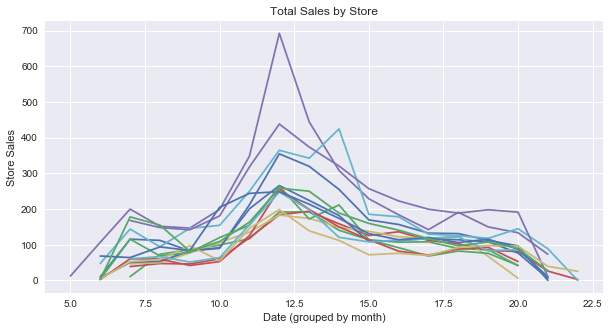

In [441]:
storeIDs = np.unique(df_preprocessed['Store_ID'])
#df['year_month'] = df['date'].dt.to_period(freq='M').dt.to_timestamp()

recent = df[df['date'] > '2017-07-01']
plt.figure(figsize=(10,5))
plt.title("Total Sales by Store")
plt.xlabel("Date (grouped by month)")
plt.ylabel("Store Sales")
for storeID in storeIDs:
    plt.plot(recent[recent['Store_ID'] == storeID].groupby('Hour')['SalesRevenue'].mean())
plt.show()

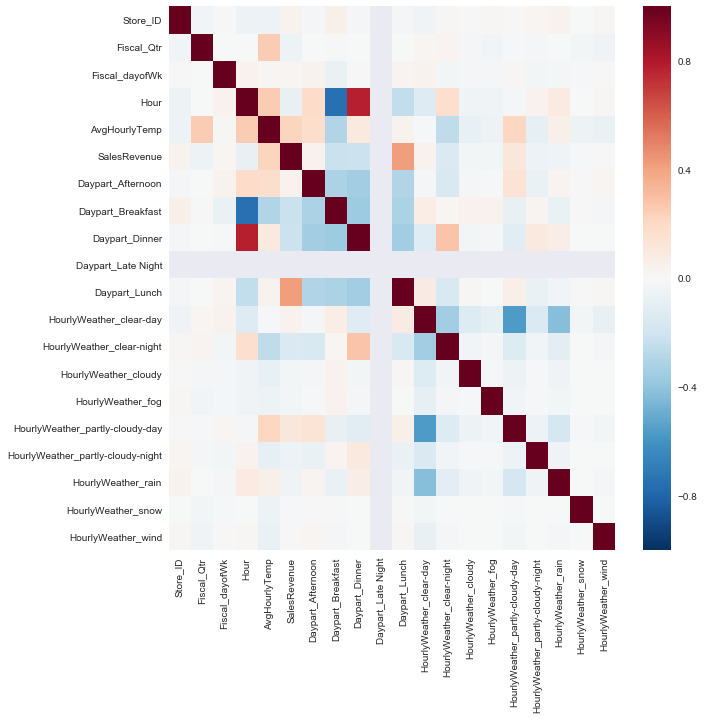

In [420]:
import seaborn as sns
corr = df.corr()
fig_size = (10, 10)
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

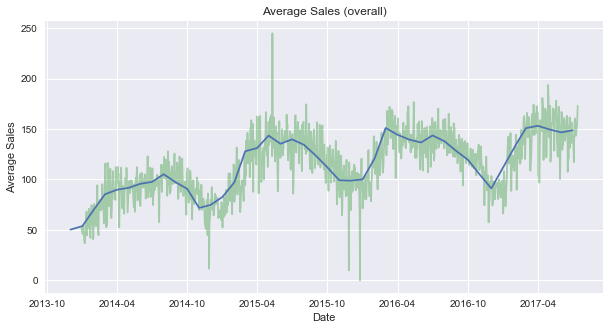

In [421]:
plt.figure(figsize=(10,5))
plt.title("Average Sales (overall)")
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.plot(df.groupby('date')['SalesRevenue'].mean(), alpha=.3, color='g')
plt.plot(df.groupby('year_month')['SalesRevenue'].mean())
plt.show()


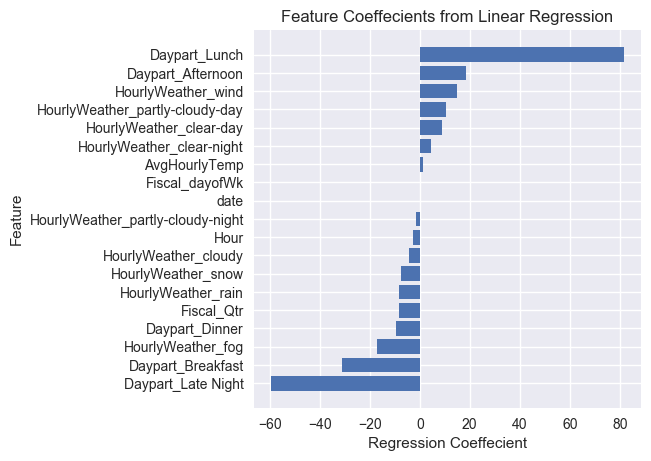

In [427]:
def regression_model(df_input):
    temp = df_input.copy()
    #temp = preprocess_data(temp)
    temp['date'] = pd.to_timedelta(temp['date']).dt.total_seconds().astype(int)

    df = temp.copy()
    
    #normer = preprocessing.Normalizer()
    #scaler = preprocessing.MinMaxScaler(feature_range=(-1000,1000))
    #df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    #df = pd.DataFrame(normer.fit_transform(df), columns=df.columns)

    #print(np.mean(X['Daypart_Afternoon']))
    cols_to_norm = ['date','Fiscal_Qtr', 'Fiscal_dayofWk', 'Hour', 'AvgHourlyTemp']
    
    #df[cols_to_norm] =  df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    X = df.drop(['SalesRevenue','Store_ID'], axis=1)
    y = df['SalesRevenue']

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    
    coef_df = pd.DataFrame({'Feature'  : X.columns,
                         'Coeffecient' : regr.coef_
                        })
    coef_df.set_index('Feature', inplace=True)
    
    #scaler = preprocessing.MinMaxScaler(feature_range=(-10,10))
    #coef_df = pd.DataFrame(scaler.fit_transform(coef_df), columns=coef_df.columns)
    
    coef_df.sort_values(by='Coeffecient', inplace=True)

    plt.figure(figsize=(5,5),dpi=100)
    plt.title("Feature Coeffecients from Linear Regression")
    plt.xlabel("Regression Coeffecient")
    plt.ylabel("Feature")
    plt.barh(range(len(coef_df)), coef_df['Coeffecient'])
    plt.yticks(range(len(coef_df)), coef_df.index.values)
    plt.show()
    
    return X, regr, df, coef_df
    
regr_df, regr, scaled_df, coef_df = regression_model(df_preprocessed)

In [461]:
def trainLGBM_all(df, targetFeature):

    temp = df.copy()
    temp['time'] = pd.to_timedelta(temp['date']).dt.total_seconds().astype(int)
    
    temp.dropna(inplace=True)
    
    #temp = temp[temp['Store_ID'] == store_ID]
    #size = temp.shape[0]
    #print("Shape for Store {0} = {1}".format(store_ID, size))
    
    split_date = '2017-07-13'
    temp = temp[temp['date'] <= split_date]

    xDrop = ['SalesRevenue','date']  
    X = temp.drop(xDrop, axis=1, errors='ignore')
    y = temp[targetFeature]
    
    #print("Initializing classifier. . .")
    gbm = lgb.LGBMRegressor(objective='regression',
                             metric='l2',
                             learning_rate=0.1,
                             #n_estimators=50,
                             #sub_feature=.514492,
                             #num_leaves=255,
                             #max_depth=7,
                             #min_data=32,
                             verbosity=0,
                             #bagging_fraction=0.85,
                             #lambda_l1=.018953,
                             #lambda_l2=.05242,
                             bagging_freq=5,
                             nthread=8,
                             silent=True)
    
    #gbm = linear_model.LinearRegression()

    #gbm.fit(X_train, y_train)
    #y_pred = gbm.predict(X_test)
    #score = r2_score(y_test, y_pred)
    #print("R2 Score is : {}".format(score))
    
    # Predict for specified criteria
    criteria = pd.DataFrame({'Store_ID' : 666,
                             'Fiscal_Qtr' : 3,
                             'Fiscal_dayofWk' : 6,
                             'Hour' : 12, 
                             'AvgHourlyTemp' : 86,
                             'Daypart_Afternoon' : 0,
                             'Daypart_Breakfast' : 0,
                             'Daypart_Dinner' : 0,
                             'Daypart_Late Night' : 0, 
                             'Daypart_Lunch' : 1,
                             'HourlyWeather_clear-day' : 1,
                             'HourlyWeather_clear-night' : 0, 
                             'HourlyWeather_cloudy' : 0,
                             'HourlyWeather_fog' : 0, 
                             'HourlyWeather_partly-cloudy-day' : 0,
                             'HourlyWeather_partly-cloudy-night' : 0,
                             'HourlyWeather_rain' : 0,
                             'HourlyWeather_snow' : 0,
                             'HourlyWeather_wind' : 0, 
                             'time' : 1500076800}, index=[0])

  
    i = 0
    cv = KFold(n_splits=3)
    for train, test in cv.split(X, y):
        #print(np.size(train))
        #print(np.size(test))
        #return X.iloc[train,:], y[train]
        gbm.fit(X.iloc[train,:], y[train],
                eval_set=[(X.iloc[test,:], y[test])],
                eval_metric='l2',
                early_stopping_rounds=3)
        
        y_pred = gbm.predict(X.iloc[test,:], num_iteration=gbm.best_iteration_)
        
        # Compute R2
        score = r2_score(y[test], y_pred[:, 1])
        scores.append(score)
        i += 1

    IDs         = []
    predictions = []
    storeIDs = np.unique(temp['Store_ID'])
    for ID in storeIDs:
        IDs.append(ID)
        criteria['Store_ID'] = ID
        predictions.append(gbm.predict(criteria, num_iteration=gbm.best_iteration_))
        
    predictions_df = pd.DataFrame({'Store_ID'           : IDs,
                                   'Revenue_Prediction' : predictions}).set_index('Store_ID')

    return scores, predictions_df

In [463]:
def trainLGBM(df, targetFeature, store_ID):

    temp = df.copy()
    temp['time'] = pd.to_timedelta(temp['date']).dt.total_seconds().astype(int)
    
    temp = temp[temp['Store_ID'] == store_ID]
    size = temp.shape[0]
    #print("Shape for Store {0} = {1}".format(store_ID, size))
    
    train_test_split_date = '2017-07-01'
    train = temp[temp['date'] <= train_test_split_date]
    test  = temp[temp['date'] >  train_test_split_date]
    
    #print("Train shape : {}".format(train.shape))
    #print("Test shape  : {}".format(test.shape))

    xDrop = ['SalesRevenue','date']
    
    X_train = train.drop(xDrop, axis=1, errors='ignore')
    y_train = train[targetFeature]
    
    X_test = test.drop(xDrop, axis=1, errors='ignore')
    y_test = test[targetFeature]
    
    #print("Training on {0}".format(targetFeature))
    
    #print("Initializing classifier. . .")
    gbm = lgb.LGBMRegressor(objective='regression',
                             metric='l2',
                             learning_rate=0.1,
                             n_estimators=50,
                             sub_feature=.514492,
                             num_leaves=255,
                             max_depth=7,
                             min_data=32,
                             verbosity=0,
                             bagging_fraction=0.85,
                             lambda_l1=.018953,
                             lambda_l2=.05242,
                             bagging_freq=5,
                             nthread=8,
                             silent=True)
    
    #gbm = linear_model.LinearRegression()

    gbm.fit(X_train, y_train)
    #print("gbm.fit: X_train={0} y_Train={1}".format(np.shape(x_train), np.shape(y_train)))

    y_pred = gbm.predict(X_test)
    #print("r2_score: y_test={0} y_pred={1}".format(np.shape(y_test), np.shape(y_pred)))
    score = r2_score(y_test, y_pred)
    print("R2 Score is : {}".format(score))
    
    # Predict for specified criteria
    criteria = pd.DataFrame({'Store_ID' : 666,
                             'Fiscal_Qtr' : 3,
                             'Fiscal_dayofWk' : 6,
                             'Hour' : 12, 
                             'AvgHourlyTemp' : 86,
                             'Daypart_Afternoon' : 0,
                             'Daypart_Breakfast' : 0,
                             'Daypart_Dinner' : 0,
                             'Daypart_Late Night' : 0, 
                             'Daypart_Lunch' : 1,
                             'HourlyWeather_clear-day' : 1,
                             'HourlyWeather_clear-night' : 0, 
                             'HourlyWeather_cloudy' : 0,
                             'HourlyWeather_fog' : 0, 
                             'HourlyWeather_partly-cloudy-day' : 0,
                             'HourlyWeather_partly-cloudy-night' : 0,
                             'HourlyWeather_rain' : 0,
                             'HourlyWeather_snow' : 0,
                             'HourlyWeather_wind' : 0, 
                             'time' : 1500076800}, index=[0])

    #IDs         = []
    #predictions = []
    #storeIDs = np.unique(temp['Store_ID'])
    #for ID in storeIDs:
    #    IDs.append(ID)
    #    criteria['Store_ID'] = ID
    #    predictions.append(gbm.predict(criteria))
    #    
    #predictions_df = pd.DataFrame({'Store_ID'           : IDs,
    #                               'Revenue_Prediction' : predictions}).set_index('Store_ID')

    prediction = gbm.predict(criteria)

    return score, y_pred, gbm, prediction, size

In [472]:
print("LGBM_Store_Predictions_{0}".format(int(time.time())))

LGBM_Store_Predictions_1532127787


In [464]:
IDs         = []
predictions = []
sizes       = []
r2s         = []
storeIDs = np.unique(temp['Store_ID'])
for ID in storeIDs:
    IDs.append(ID)
    score, y_pred, gbm, prediction, size = trainLGBM(df_neat, 'SalesRevenue', ID)
    sizes.append(size)
    predictions.append(prediction[0])
    r2s.append(score)
    
predictions_df = pd.DataFrame({'Store_ID'           : IDs,
                               'Size'               : sizes,
                               'R2_Score'           : r2s,
                               'Revenue_Prediction' : predictions}).set_index('Store_ID')
    


R2 Score is : 0.7082565050422336
R2 Score is : 0.4977725395149053
R2 Score is : 0.49510240559763863
R2 Score is : 0.7538144104114809
R2 Score is : 0.4202351584937346
R2 Score is : 0.18285392611567464
R2 Score is : 0.5731262668891037
R2 Score is : 0.390968068704721
R2 Score is : 0.5277732973301685
R2 Score is : 0.6785767133674847
R2 Score is : 0.16745365536387835
R2 Score is : 0.4341935480545934
R2 Score is : 0.348192789259948
R2 Score is : 0.4816220936952188


In [478]:
predictions_df['Revenue_Prediction'].values[0][0]

123.92175263958063

In [430]:
scores, predictions_df = trainLGBM_all(df, 'SalesRevenue')
#x_train, y_train = trainLGBM_all(df, 'SalesRevenue')

y_train

[1]	valid_0's l2: nan
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's l2: nan
[3]	valid_0's l2: nan
[4]	valid_0's l2: nan


TypeError: 'NoneType' object is not iterable

In [350]:
predictions_df

,R2_Score,Revenue_Prediction,Size
Store_ID,,,
2,0.787647,[79.46732928351264],15539
11,0.516806,[56.83131791917647],14905
16,0.611689,[25.50471411546752],17504
17,0.871103,[159.64386142365464],18668
18,-60.598929,[36.732351860199586],14955
20,0.561303,[101.33971506343111],13980
21,0.826940,[58.78178208068878],7102
22,0.230568,[108.86468331166768],6178
23,0.809912,[109.16836647421897],500


In [321]:
df[df['date'] > '2017-06-01'].groupby('Hour')['SalesRevenue'].median()

Hour
0       0.000
5      11.250
6      40.680
7      73.960
8      76.980
9      68.745
10     98.625
11    165.230
12    252.565
13    215.140
14    168.490
15    134.080
16    118.235
17    109.890
18    104.570
19     98.790
20     81.030
21     25.770
22      2.590
Name: SalesRevenue, dtype: float64

In [333]:
test = df.sort_values(by='date', ascending=True)
secs1 = pd.to_timedelta(test['date']).dt.total_seconds().astype(int).tail()[0]
1500076800 - secs1

86400

In [334]:
86400 / 60 / 60 / 24

1.0